test_regr1 :　回帰問題
　　参考：https://axa.biopapyrus.jp/deep-learning/object-classification/regression-multiple-features.html

In [1]:
#　colaboraory用: Google drive をマウントする
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# colaboratory用: フォルダを移る
%cd "drive/My Drive/Colab Notebooks/"

/content/drive/My Drive/Colab Notebooks


フォルダは自分の指定のものに変更して下さい。

In [3]:
%cd "ctorch211122/MiniCTorch_Prototype/notebook"

/content/drive/My Drive/Colab Notebooks/ctorch211122/MiniCTorch_Prototype/notebook


ライブラリのimport

In [4]:
!pip install lark-parser

In [5]:
import sys
sys.path.append("../")

import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import minictorch.generator as GN
import minictorch.converter as CV

サンプルデータ

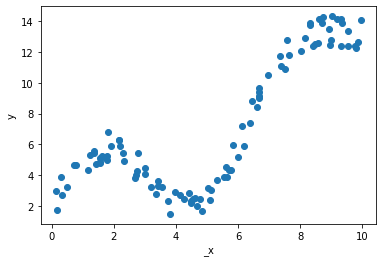

In [6]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(2020)

_x = np.random.uniform(0, 10, 100)

x1 = np.sin(_x)
x2 = np.exp(_x / 5)
x = np.stack([x1, x2], axis=1)
y = 3 * x1 + 2 * x2 + np.random.uniform(-1, 1, 100)

fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(_x, y)
ax.set_xlabel('_x')
ax.set_ylabel('y')
fig.show()

ニューラルネットワークの定義

In [7]:
"""
def mean_squared_error( x0, x1 ):
    diff = x0 - x1
    y = (diff**2).sum() / len(diff)
    return y;
"""

class Net(torch.nn.Module):
  def __init__( self, t ):
    super(Net, self).__init__()
    self.fc1 = torch.nn.Linear(2, 64)
    self.fc2 = torch.nn.Linear(64, 32)
    self.fc3 = torch.nn.Linear(32, 1)
    self.target = t
    self.kind = 0;

  def forward(self, x):
    x = torch.nn.functional.relu(self.fc1(x))
    x = torch.nn.functional.relu(self.fc2(x))
    x = self.fc3(x)
    self.out = x
    if self.kind == 1: return 0.0
    #if not nn.Module().training:  return 0.0

    #y = mean_squared_error( x, self.target )
    loss = nn.MSELoss()
    y = loss( x, self.target )
    return y

In [8]:
def generate_json( json_path, input, target ):
    model = Net( target )

    model.eval()
    with torch.no_grad():
        print("[SAVE]", json_path )
        GN.generate_minictorch_file( model, input, json_path )

    return model

プロジェクト名、作業フォルダ、JSONファイル名の設定

In [9]:
project = 'regr1'
folder  = './test'
json_path = folder + '/' + project +'.json'

計算グラフをJSONファイルに出力する

In [10]:
torch.manual_seed( 1 )

x_tensor = torch.from_numpy(x).float()
y_tensor = torch.from_numpy(y.reshape(-1, 1)).float()

x_tensor.requires_grad = True

model = generate_json( json_path, x_tensor, y_tensor )

[SAVE] ./test/regr1.json
skip: Net/Linear[fc1]/weight/fc1
skip: Net/Linear[fc1]/weight/fc1
skip: Net/Linear[fc2]/weight/fc2
skip: Net/Linear[fc2]/weight/fc2
skip: Net/Linear[fc3]/weight/fc3
skip: Net/Linear[fc3]/weight/fc3


一回の順伝播、逆伝播のC++コードを生成する

In [11]:
CV.convert_cpp_code( project, folder, model, x_tensor, json_path )

[JSON] ./test/regr1.json
{'name': 'Net/Linear[fc1]/weight/weight.7', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [3], 'sorted_id': 1}
{'name': 'Net/Linear[fc1]/bias/bias.7', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [3], 'sorted_id': 2}
{'name': 'Net/Linear[fc2]/weight/weight.9', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [7], 'sorted_id': 5}
{'name': 'Net/Linear[fc2]/bias/bias.9', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [7], 'sorted_id': 6}
{'name': 'Net/Linear[fc3]/weight/weight', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [11], 'sorted_id': 9}
{'name': 'Net/Linear[fc3]/bias/bias', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [11], 'sorted_id': 10}
[PARAM] ./test/regr1_param.cpp
{'name': 'input/x', 'op': 'IO Node', 'in': [], 'output_id': 0, 'shape': [100, 2], 'out': [3], 'sorted_id': 0}
{'name': 'Net/Linear[fc1]/weight/weight.7',

In [12]:
# check code
with torch.set_grad_enabled(True):
  #model.train()
  loss = model( x_tensor )
  print("loss ",loss)
  loss.backward()
  print("input",x_tensor.grad)

loss  tensor(67.4897, grad_fn=<MseLossBackward0>)
input tensor([[ 6.7952e-03,  4.8823e-04],
        [-8.7210e-03,  1.5778e-03],
        [-1.4692e-03, -5.7917e-04],
        [ 5.0851e-03, -3.3004e-03],
        [-3.1918e-03, -6.0882e-04],
        [ 7.3107e-03, -3.7030e-03],
        [ 8.1786e-03, -5.5729e-03],
        [-4.1216e-03, -7.8619e-04],
        [-5.0728e-03,  8.8635e-04],
        [ 3.6004e-04, -8.5637e-05],
        [ 3.5354e-04, -8.4093e-05],
        [-4.3465e-03,  7.3654e-04],
        [-4.0067e-03,  6.7897e-04],
        [-3.4841e-03, -5.3126e-04],
        [-3.7277e-03, -7.1106e-04],
        [ 6.2141e-05,  9.6287e-04],
        [ 7.2834e-03, -3.6891e-03],
        [-4.4959e-03, -3.9537e-04],
        [ 3.9924e-04, -9.4963e-05],
        [-3.5350e-03, -7.2280e-04],
        [-5.3305e-04,  2.0967e-03],
        [ 4.2013e-04, -9.9933e-05],
        [-4.3099e-03, -3.7900e-04],
        [-5.4636e-05,  1.1250e-03],
        [-2.3520e-03, -7.7544e-04],
        [ 6.5594e-05,  1.0163e-03],
        

C++コードをコンパイル、リンクする

In [13]:
!g++ -std=c++14 ./test/regr1.cpp ./test/regr1_param.cpp -D_NOTEBOOK -I ../../../xtensor  -lcblas -o ./test/regr1

(注意) xtensorフォルダにxtensor関連のincludeファイルを置いています。各自の環境に合わせて変更して下さい。

In [14]:
!./test/regr1

### forward computation ...
 67.489609
### backward computation ...
input_grad{{ 0.006795,  0.000488},
 {-0.008721,  0.001578},
 {-0.001469, -0.000579},
 { 0.005085, -0.0033  },
 {-0.003192, -0.000609},
 { 0.007311, -0.003703},
 { 0.008179, -0.005573},
 {-0.004122, -0.000786},
 {-0.005073,  0.000886},
 { 0.00036 , -0.000086},
 { 0.000354, -0.000084},
 {-0.004346,  0.000737},
 {-0.004007,  0.000679},
 {-0.003484, -0.000531},
 {-0.003728, -0.000711},
 { 0.000062,  0.000963},
 { 0.007283, -0.003689},
 {-0.004496, -0.000395},
 { 0.000399, -0.000095},
 {-0.003535, -0.000723},
 {-0.000533,  0.002097},
 { 0.00042 , -0.0001  },
 {-0.00431 , -0.000379},
 {-0.000055,  0.001125},
 {-0.002352, -0.000775},
 { 0.000066,  0.001016},
 {-0.000282, -0.002514},
 {-0.000073,  0.000737},
 { 0.000386, -0.000092},
 {-0.001335, -0.000345},
 { 0.00039 , -0.000093},
 {-0.007612,  0.001377},
 {-0.002627, -0.000428},
 {-0.001714, -0.000279},
 {-0.004498,  0.000786},
 {-0.002171,  0.001349},
 {-0.005939, -0.000522

学習ループの実行(python版)

In [15]:
torch.manual_seed( 1 )
 
x_tensor = torch.from_numpy(x).float()
y_tensor = torch.from_numpy(y.reshape(-1, 1)).float()

x_tensor.requires_grad = True

net = Net( y_tensor )
net.train()

lr = 0.01
opt=torch.optim.SGD(net.parameters(), lr)

epoch_loss = []
for epoch in range(300):
  loss = net(x_tensor)
  print("loss",loss)
  epoch_loss.append( loss )

  opt.zero_grad()
  loss.backward()
  opt.step();

loss tensor(67.4897, grad_fn=<MseLossBackward0>)
loss tensor(36.1833, grad_fn=<MseLossBackward0>)
loss tensor(3.8057, grad_fn=<MseLossBackward0>)
loss tensor(5.0003, grad_fn=<MseLossBackward0>)
loss tensor(8.2970, grad_fn=<MseLossBackward0>)
loss tensor(23.9235, grad_fn=<MseLossBackward0>)
loss tensor(8.9370, grad_fn=<MseLossBackward0>)
loss tensor(25.9405, grad_fn=<MseLossBackward0>)
loss tensor(5.5347, grad_fn=<MseLossBackward0>)
loss tensor(14.0332, grad_fn=<MseLossBackward0>)
loss tensor(10.9607, grad_fn=<MseLossBackward0>)
loss tensor(31.0107, grad_fn=<MseLossBackward0>)
loss tensor(1.5975, grad_fn=<MseLossBackward0>)
loss tensor(1.5555, grad_fn=<MseLossBackward0>)
loss tensor(1.6678, grad_fn=<MseLossBackward0>)
loss tensor(2.3511, grad_fn=<MseLossBackward0>)
loss tensor(3.6467, grad_fn=<MseLossBackward0>)
loss tensor(9.3329, grad_fn=<MseLossBackward0>)
loss tensor(9.3094, grad_fn=<MseLossBackward0>)
loss tensor(26.3715, grad_fn=<MseLossBackward0>)
loss tensor(1.4412, grad_fn=<Mse

評価データを生成する。

In [16]:
nd = 1000
d1 = np.linspace(0.,10.,nd)
x1 = np.sin(d1)
x2 = np.exp(d1 / 5)
d2 = np.stack([x1, x2], axis=1)

dd = torch.from_numpy(d2).float()

net.kind = 1
net.eval()
loss = net( dd )

y_pred = net.out.data.numpy()

収束状況グラフを描画する

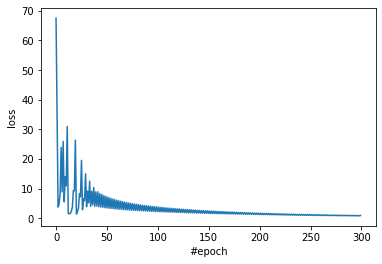

In [17]:
import matplotlib.pyplot as plt

# convergence graph
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(epoch_loss))), epoch_loss)
ax.set_xlabel('#epoch')
ax.set_ylabel('loss')
fig.show()

評価データを描画する

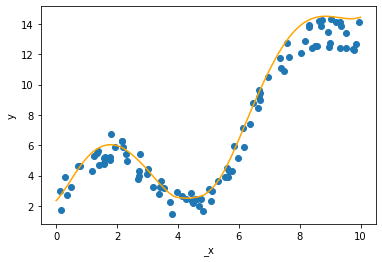

In [18]:
# prediction result
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(_x, y )
ax.plot( d1, y_pred, c='orange')
ax.set_xlabel('_x')
ax.set_ylabel('y')
fig.show()

学習用データファイル、学習ループのC++コードを生成する

In [19]:
nd = 1000
d1 = np.linspace(0.,10.,nd)
x1 = np.sin(d1)
x2 = np.exp(d1 / 5)
d2 = np.stack([x1, x2], axis=1)

CV.convert_data_file( project, folder, inp_data=d2 )
CV.convert_train_code( project, folder, json_path, sol="regression", epochs=300, batch=0, inp_data=d2 )

datafile key :  inp_data
[DATA] ./test/regr1_data.cpp
[JSON] ./test/regr1.json
epoch_num :  300
batch_size :  0
lr :  0.01
inp  shape :  1 {1000,2}
inp2 shape :  0 
target shape :  0 
pred_num :  1000
div :  False
pred_pos :  -1 0 0
el  0 1  :  input/x IO Node [] 0 -1
el  3 1  :  Net/Linear[fc1]/input.1 aten::linear [0, 1, 2] 0 -1
el  4 1  :  Net/input.3 aten::relu [3] 0 -1
el  7 1  :  Net/Linear[fc2]/input.5 aten::linear [4, 5, 6] 0 -1
el  8 1  :  Net/input.7 aten::relu [7] 0 -1
el  11 1  :  Net/Linear[fc3]/input.9 aten::linear [8, 9, 10] 0 -1
el  18 1  :  Net/44 aten::mse_loss [15, 16, 17] 0 -1
eval no : 18 -> type= 1  :  11 -1
last cmd: 18
------
solution : regression
pred_no   : 11
target_no : -1
class_no  : 0
pred_no :  11
[TRAIN]  ./test/regr1_train.cpp


学習用C++コードをコンパイル、リンクする

In [20]:
!g++ -std=c++14 ./test/regr1.cpp ./test/regr1_param.cpp ./test/regr1_train.cpp ./test/regr1_data.cpp -D_NOTEBOOK -D_TRAIN -I ../../../xtensor -lcblas -o ./test/regr1_train

(注意) xtensorフォルダにxtensor関連のincludeファイルを置いています。

In [21]:
!./test/regr1_train

epoch_num : 300
epoch 0 - loss 67.4896
epoch 1 - loss 36.1833
epoch 2 - loss 3.80568
epoch 3 - loss 5.00023
epoch 4 - loss 8.29694
epoch 5 - loss 23.9232
epoch 6 - loss 8.93713
epoch 7 - loss 25.941
epoch 8 - loss 5.53438
epoch 9 - loss 14.032
epoch 10 - loss 10.9611
epoch 11 - loss 31.0119
epoch 12 - loss 1.59739
epoch 13 - loss 1.55513
epoch 14 - loss 1.66704
epoch 15 - loss 2.34869
epoch 16 - loss 3.64226
epoch 17 - loss 9.31862
epoch 18 - loss 9.30901
epoch 19 - loss 26.372
epoch 20 - loss 1.44155
epoch 21 - loss 2.284
epoch 22 - loss 3.39256
epoch 23 - loss 8.37133
epoch 24 - loss 7.2635
epoch 25 - loss 19.5551
epoch 26 - loss 2.92081
epoch 27 - loss 6.62633
epoch 28 - loss 5.92831
epoch 29 - loss 15.0172
epoch 30 - loss 3.91594
epoch 31 - loss 9.14582
epoch 32 - loss 5.23805
epoch 33 - loss 12.5484
epoch 34 - loss 4.02986
epoch 35 - loss 9.12672
epoch 36 - loss 4.5776
epoch 37 - loss 10.4065
epoch 38 - loss 4.05323
epoch 39 - loss 8.92107
epoch 40 - loss 4.11703
epoch 41 - loss 8

In [22]:
# read output file from c++ code
path = folder + '/' + project + '.out'
f1 = open( path, 'r' )

epoch_loss = []

datalist = f1.readlines()
for data in datalist:
  epoch_loss.append( float(data) )

f1.close()

print("epoch =", len(epoch_loss))
print( epoch_loss)

path = folder + '/' + project + '.pred'
f2 = open( path, 'r' )

x_new = []
y_pred = []
k = 0
datalist = f2.readlines()
for data in datalist:
  ds = data.split(',')
  if k == 0:
    n1 = ds[0]
    n2 = ds[1]
    print("n1,n2 ",n1,n2)
  else:
    x_new.append( float(d1[k-1]) )
    y_pred.append( float(ds[0]) )
  k = k+1

f2.close()

print("pred =", len(x_new))
print( x_new )
print( y_pred )

epoch = 300
[67.489609, 36.1833, 3.805676, 5.000233, 8.296941, 23.923243, 8.937128, 25.940987, 5.534382, 14.032016, 10.961112, 31.011883, 1.597391, 1.555127, 1.66704, 2.348695, 3.64226, 9.31862, 9.309009, 26.371971, 1.441545, 2.283998, 3.392555, 8.371325, 7.2635, 19.555117, 2.920814, 6.626325, 5.928308, 15.017187, 3.915945, 9.145824, 5.238048, 12.548371, 4.029859, 9.126719, 4.577601, 10.406542, 4.053226, 8.92107, 4.117025, 8.970004, 3.907642, 8.340606, 3.824687, 8.049696, 3.706045, 7.685133, 3.610443, 7.388703, 3.51833, 7.110254, 3.433341, 6.856628, 3.354629, 6.624643, 3.279809, 6.40786, 3.209304, 6.205905, 3.142902, 6.017651, 3.079683, 5.841084, 3.020222, 5.675284, 2.961112, 5.512842, 2.905596, 5.363312, 2.852673, 5.222939, 2.803398, 5.09347, 2.757456, 4.970007, 2.712839, 4.857723, 2.670183, 4.744208, 2.628574, 4.637481, 2.588186, 4.537941, 2.549103, 4.436661, 2.511497, 4.343006, 2.476508, 4.259149, 2.442358, 4.171561, 2.408118, 4.09119, 2.375538, 4.009, 2.343258, 3.931981, 2.311956, 

収束状況グラフを描画する

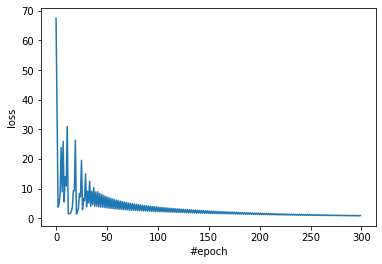

In [23]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(epoch_loss))), epoch_loss)
ax.set_xlabel('#epoch')
ax.set_ylabel('loss')
fig.show()

評価データを描画する

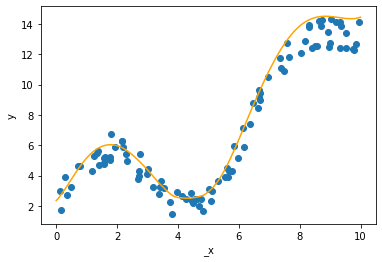

In [24]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(_x, y)
ax.plot( x_new, y_pred, c='orange')
ax.set_xlabel('_x')
ax.set_ylabel('y')
fig.show()